# Precision-recall vs. ROC lab

In this lab you'll explore the differences between the ROC and PRAUC plot, as well as what changes when you optimize a gridsearch for different metrics - in this case changing the optimization from accuracy to "f1-score".

---

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import patsy

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

### Load a classification dataset

The data you can use is up to you for this lab. I've put a dataset on police killings in the datasets folder, which I will use here (path to my location is below). 

This dataset is small though, and model's don't fit that well on it, so you may want to use something else if you want to see big differences... If you do choose something else, make sure you can create at least two binary predictor variables in it.

In [70]:
sos = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/stack_overflow_surveys/survey_simple_cleaned_nonull.csv')

In [71]:
pk = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/police_killings/police-killings.csv')

---

### Clean the data

In [72]:
pk.head()

,Unnamed: 0,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,lawenforcementagency,cause,armed,county_income
0,0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,Millbrook Police Department,Gunshot,No,54766
1,1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,Rapides Parish Sheriff's Office,Gunshot,No,40930
2,2,Aaron Siler,26,Male,White,March,14,2015,22nd Ave and 56th St,Kenosha,WI,Kenosha Police Department,Gunshot,No,54930
3,3,Aaron Valdez,25,Male,Hispanic/Latino,March,11,2015,3000 Seminole Ave,South Gate,CA,South Gate Police Department,Gunshot,Firearm,55909
4,4,Adam Jovicic,29,Male,White,March,19,2015,364 Hiwood Ave,Munroe Falls,OH,Kent Police Department,Gunshot,No,49669


In [73]:
pk.drop('Unnamed: 0', axis=1, inplace=True)

In [74]:
pk.gender.unique()

array(['Male', 'Female'], dtype=object)

In [75]:
pk.gender = pk.gender.map(lambda x: 1 if x == 'Male' else 0)

In [76]:
pk.raceethnicity.unique()

array(['Black', 'White', 'Hispanic/Latino', 'Unknown',
       'Asian/Pacific Islander', 'Native American'], dtype=object)

In [77]:
pk.cause.unique()

array(['Gunshot', 'Death in custody', 'Taser', 'Struck by vehicle',
       'Unknown'], dtype=object)

In [78]:
pk.armed.unique()

array(['No', 'Firearm', 'Non-lethal firearm', 'Other', 'Knife', 'Vehicle',
       'Unknown', 'Disputed'], dtype=object)

In [79]:
pk.state.unique()

array(['AL', 'LA', 'WI', 'CA', 'OH', 'AZ', 'TX', 'MI', 'IN', 'TN', 'GA',
       'VA', 'NE', 'KS', 'OK', 'OR', 'NH', 'FL', 'MA', 'PA', 'WA', 'AR',
       'IA', 'NC', 'NM', 'DC', 'ID', 'CO', 'HI', 'KY', 'SC', 'WV', 'UT',
       'MO', 'MD', 'NY', 'NJ', 'IL', 'CT', 'MS', 'NV', 'MT', 'AK', 'MN',
       'ME', 'DE', 'WY'], dtype=object)

In [80]:
pk.columns

Index([u'name', u'age', u'gender', u'raceethnicity', u'month', u'day', u'year',
       u'streetaddress', u'city', u'state', u'lawenforcementagency', u'cause',
       u'armed', u'county_income'],
      dtype='object')

---

### Create two or three binary target variables to predict

In [81]:
y_gun = pk.cause.map(lambda x: 1 if x == 'Gunshot' else 0)
y_notarmed = pk.armed.map(lambda x: 1 if x == 'No' else 0)
y_black = pk.raceethnicity.map(lambda x: 1 if x == 'Black' else 0)


In [94]:
y_so_female = [1 if x == 0 else 0 for x in sos.male.values]

---

### Using patsy or manually, create corresponding predictor matrices for your target variables

In [87]:
gun_f = '~ age + county_income + C(gender) + C(raceethnicity) + C(armed) + C(year) + C(state) + -1'
X_gun = patsy.dmatrix(gun_f, data=pk, return_type='dataframe')
print X_gun.shape

(467, 62)


In [88]:
notarmed_f = '~ age + county_income + C(gender) + C(raceethnicity) + C(cause) + C(year) + C(state) -1'
X_notarmed = patsy.dmatrix(notarmed_f, data=pk, return_type='dataframe')
print X_notarmed.shape

(467, 59)


In [89]:
black_f = '~ age + county_income + C(gender) + C(armed) + C(cause) + C(year) + C(state) -1'
X_black = patsy.dmatrix(black_f, data=pk, return_type='dataframe')
print X_black.shape

(467, 61)


In [90]:
sos.columns

Index([u'so_region', u'age_midpoint', u'occupation', u'occupation_group',
       u'experience_midpoint', u'salary_midpoint', u'big_mac_index', u'aliens',
       u'programming_ability', u'employment_status', u'industry',
       u'company_size_range', u'team_size_range', u'women_on_team', u'remote',
       u'job_satisfaction', u'commit_frequency', u'hobby', u'dogs_vs_cats',
       u'desktop_os', u'unit_testing', u'visit_frequency', u'open_to_new_job',
       u'interview_likelihood', u'star_wars_vs_star_trek', u'agree_tech',
       u'agree_notice', u'agree_problemsolving', u'agree_diversity',
       u'agree_adblocker', u'agree_alcohol', u'agree_loveboss',
       u'agree_nightcode', u'agree_legacy', u'agree_mars',
       u'important_variety', u'important_control', u'important_sameend',
       u'important_newtech', u'important_buildnew', u'important_buildexisting',
       u'important_promotion', u'important_companymission', u'important_wfh',
       u'male'],
      dtype='object')

In [91]:
sos.dtypes

so_region                    object
age_midpoint                float64
occupation                   object
occupation_group             object
experience_midpoint         float64
salary_midpoint             float64
big_mac_index               float64
aliens                        int64
programming_ability         float64
employment_status            object
industry                     object
company_size_range          float64
team_size_range             float64
women_on_team               float64
remote                       object
job_satisfaction            float64
commit_frequency            float64
hobby                       float64
dogs_vs_cats                  int64
desktop_os                   object
unit_testing                  int64
visit_frequency             float64
open_to_new_job             float64
interview_likelihood        float64
star_wars_vs_star_trek        int64
agree_tech                  float64
agree_notice                float64
agree_problemsolving        

In [96]:
sos_cats = ['desktop_os','remote','industry','employment_status','occupation_group',
            'occupation','so_region']
sos_nums = [x for x in sos.columns if x not in sos_cats+['male']]

In [98]:
so_female_f = '~ '+' + '.join(sos_nums+['C('+x+')' for x in sos_cats])+' -1'
print so_female_f

~ age_midpoint + experience_midpoint + salary_midpoint + big_mac_index + aliens + programming_ability + company_size_range + team_size_range + women_on_team + job_satisfaction + commit_frequency + hobby + dogs_vs_cats + unit_testing + visit_frequency + open_to_new_job + interview_likelihood + star_wars_vs_star_trek + agree_tech + agree_notice + agree_problemsolving + agree_diversity + agree_adblocker + agree_alcohol + agree_loveboss + agree_nightcode + agree_legacy + agree_mars + important_variety + important_control + important_sameend + important_newtech + important_buildnew + important_buildexisting + important_promotion + important_companymission + important_wfh + C(desktop_os) + C(remote) + C(industry) + C(employment_status) + C(occupation_group) + C(occupation) + C(so_region) -1


In [99]:
X_so_female = patsy.dmatrix(so_female_f, data=sos, return_type='dataframe')
print X_so_female.shape

(21527, 124)


---

### Break up your predictors and targets with train_test_split

**Use the `stratify` option! It takes as its argument the target variable vector.**

Choose a reasonable test size that's not too small. 0.3 to 0.4 is probably good, but depends on your data.

In [100]:
X_blk_train, X_blk_test, y_blk_train, y_blk_test = train_test_split(X_black, y_black, 
                                                                    stratify=y_black, test_size=0.4)
X_gun_train, X_gun_test, y_gun_train, y_gun_test = train_test_split(X_gun, y_gun, 
                                                                    stratify=y_gun, test_size=0.4)
X_narm_train, X_narm_test, y_narm_train, y_narm_test = train_test_split(X_notarmed, y_notarmed, 
                                                                    stratify=y_notarmed, test_size=0.4)

Xso_f_train, Xso_f_test, yso_f_train, yso_f_test = train_test_split(X_so_female, y_so_female, 
                                                                    stratify=y_so_female, test_size=0.4)

---

### Gridsearch best parameters for your models

For each of your target variables, optimize parameters with gridsearch **fitting on the training data from above**. We will be saving the test data for later.

It is up to you whether you want to fit a LogisticRegression or KNeighborsClassifier (or both?).

In [104]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':np.linspace(0.0001,1000.,50)
}

gun_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
notarmed_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
black_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
sof_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

gun_gs.fit(X_gun_train, y_gun_train)
notarmed_gs.fit(X_narm_train, y_narm_train)
black_gs.fit(X_blk_train, y_blk_train)
sof_gs.fit(Xso_f_train, yso_f_train)



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    9.0s finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-04,   2.04083e+01,   4.08164e+01,   6.12246e+01,
         8.16327e+01,   1.02041e+02,   1.22449e+02,   1.42857e+02,
         1.63265e+02,   1.83674e+02,   2.04082e+02,   2.24490e+02,
         2.44898e+02,   2.65306e+02,   2.85714e+02,   3.0...7e+02,   9.38776e+02,   9.59184e+02,
         9.79592e+02,   1.00000e+03]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

---

### Compare performance of your models against baseline accuracy

In [105]:
gun_lr = gun_gs.best_estimator_
print gun_gs.best_params_
print gun_gs.best_score_, np.abs(0.5 - np.mean(y_gun_train)) + 0.5

notarmed_lr = notarmed_gs.best_estimator_
print notarmed_gs.best_params_
print notarmed_gs.best_score_, np.abs(0.5 - np.mean(y_narm_train)) + 0.5

black_lr = black_gs.best_estimator_
print black_gs.best_params_
print black_gs.best_score_, np.abs(0.5 - np.mean(y_blk_train)) + 0.5

sof_lr = sof_gs.best_estimator_
print sof_gs.best_params_
print sof_gs.best_score_, np.abs(0.5 - np.mean(yso_f_train)) + 0.5


{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.878571428571 0.878571428571
{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.782142857143 0.782142857143
{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.710714285714 0.710714285714
{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.937054815732 0.937054815732


---

### Create a function to plot an ROC curve

Your function will probably take a model, and X matrix and y target vector. This way you can use `roc_curve` and `auc` to get the stuff needed for the plot.

See the sklearn example here:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()


---

### Plot ROC curves using your models and the TEST data you split off earlier

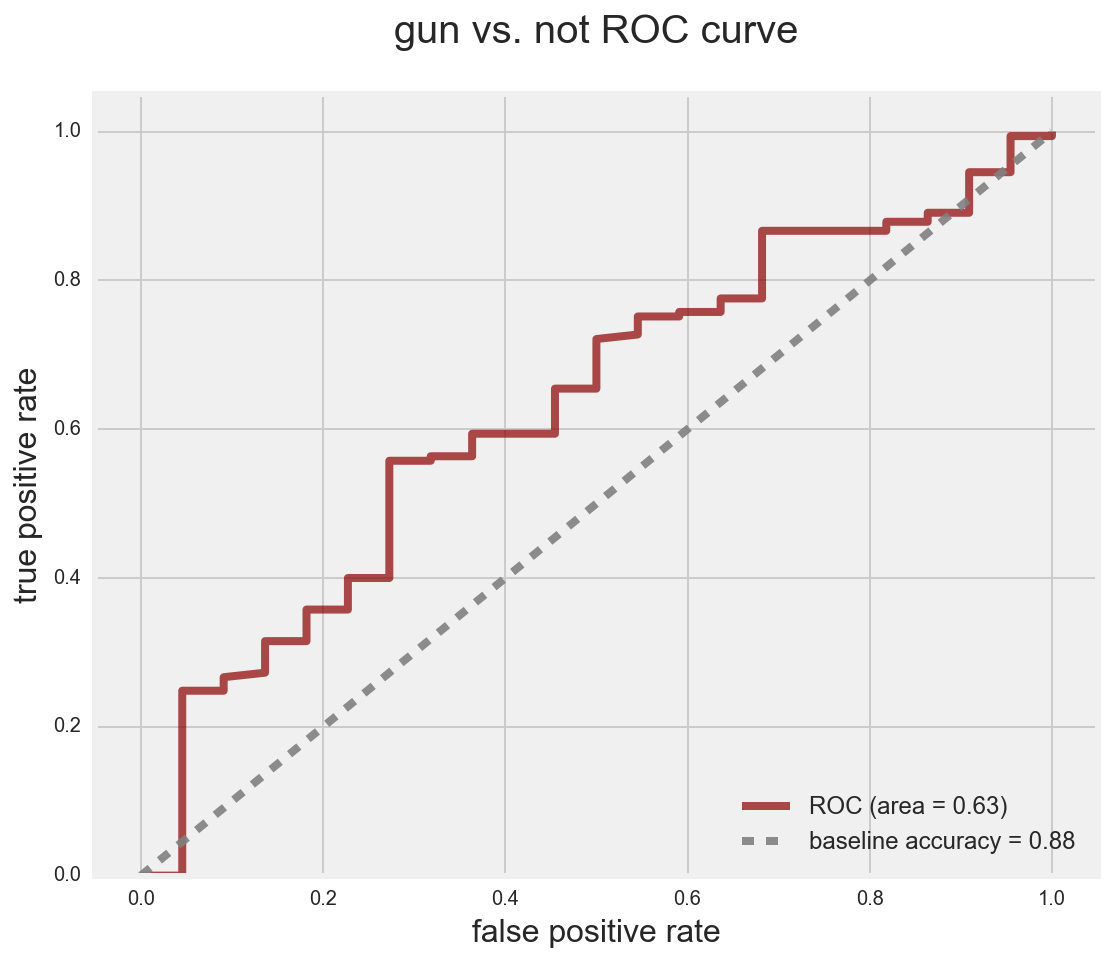

In [107]:
plot_roc(gun_lr, X_gun_test, y_gun_test, 'gun')

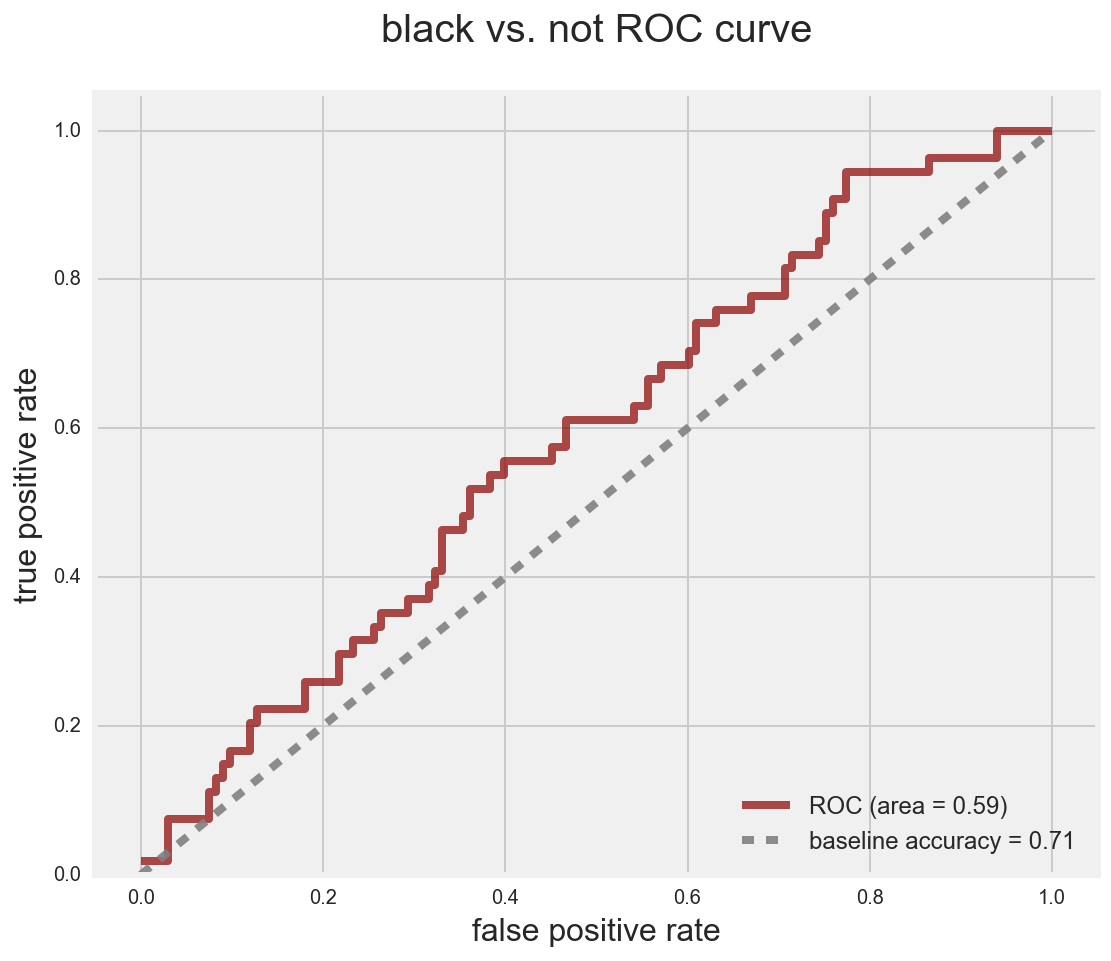

In [108]:
plot_roc(black_lr, X_blk_test, y_blk_test, 'black')

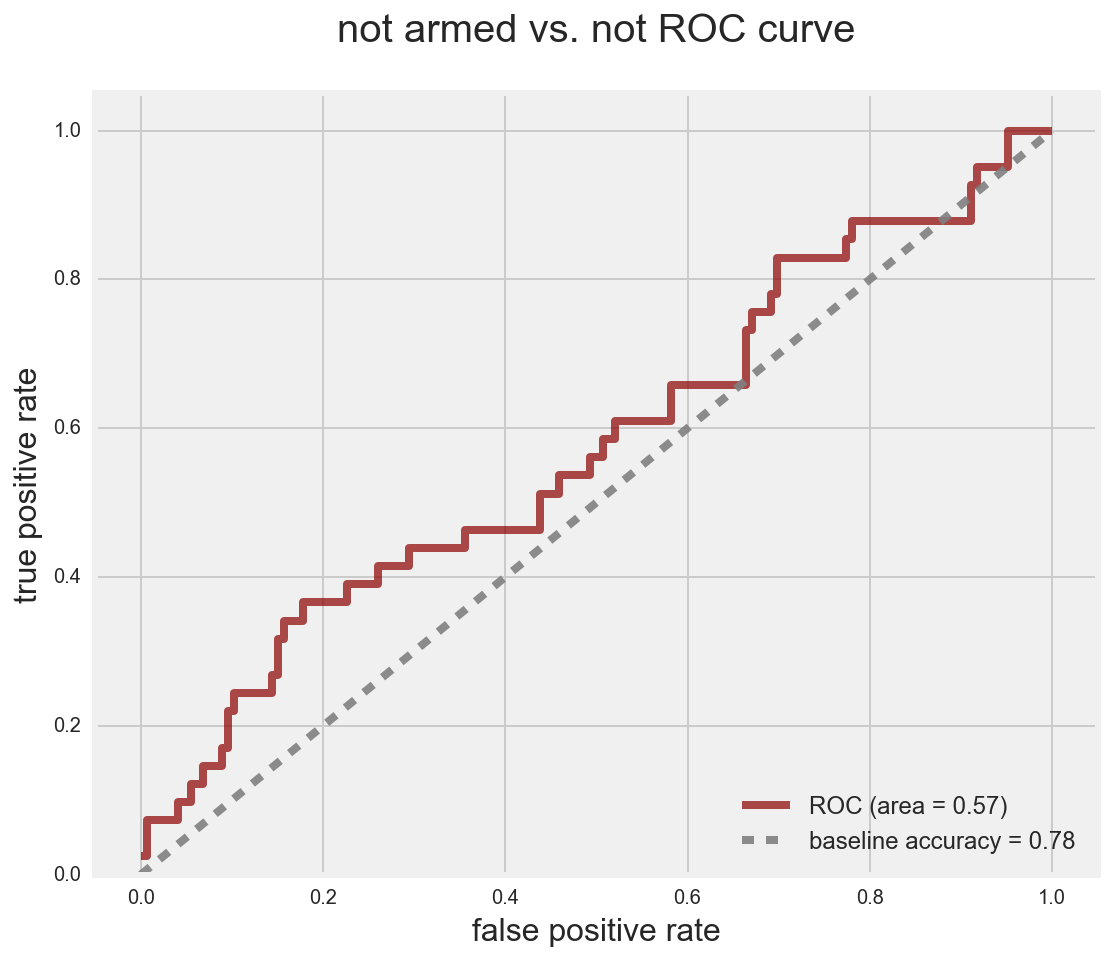

In [109]:
plot_roc(notarmed_lr, X_narm_test, y_narm_test, 'not armed')

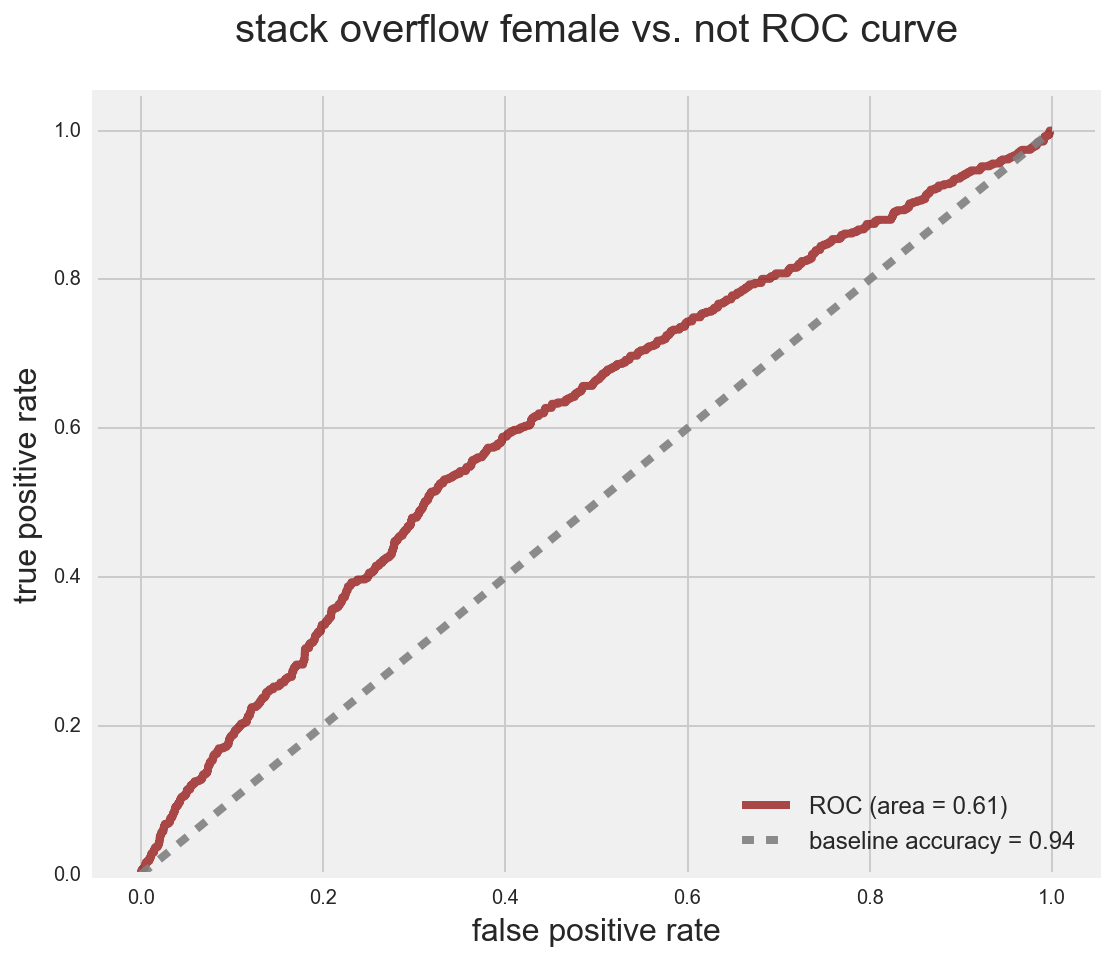

In [110]:
plot_roc(sof_lr, Xso_f_test, yso_f_test, 'stack overflow female')

---

### Calculate the confusion matrices for your models on the training and testing data

What do they tell you about the models?

In [111]:
def calc_confusion_matrix(mod, X, y, margins=False):
    pred = pd.Series(mod.predict(X), name='Predicted')
    true = pd.Series(y, name='True')
    confusion = pd.crosstab(true, pred, margins=margins)
    return confusion


In [112]:
print 'gun confusion train:'
calc_confusion_matrix(gun_lr, X_gun_train, y_gun_train, margins=True)

gun confusion train:


Predicted,1.0,All
True,,
0.0,19,19
1.0,155,155
All,174,174


In [113]:
print 'gun confusion test:'
calc_confusion_matrix(gun_lr, X_gun_test, y_gun_test, margins=True)

gun confusion test:


Predicted,1.0,All
True,,
0.0,8,8
1.0,63,63
All,71,71


In [114]:
print 'black confusion train:'
calc_confusion_matrix(black_lr, X_blk_train, y_blk_train, margins=True)

black confusion train:


Predicted,0.0,All
True,,
0.0,112,112
1.0,49,49
All,161,161


In [115]:
print 'black confusion test:'
calc_confusion_matrix(black_lr, X_blk_test, y_blk_test, margins=True)

black confusion test:


Predicted,0.0,All
True,,
0.0,54,54
1.0,24,24
All,78,78


In [116]:
print 'not armed confusion train:'
calc_confusion_matrix(notarmed_lr, X_narm_train, y_narm_train, margins=True)

not armed confusion train:


Predicted,0.0,All
True,,
0.0,138,138
1.0,34,34
All,172,172


In [117]:
print 'not armed confusion test:'
calc_confusion_matrix(notarmed_lr, X_narm_test, y_narm_test, margins=True)

not armed confusion test:


Predicted,0.0,All
True,,
0.0,58,58
1.0,19,19
All,77,77


In [118]:
print 'stack overflow female confusion train:'
calc_confusion_matrix(sof_lr, Xso_f_train, yso_f_train, margins=True)

stack overflow female confusion train:


Predicted,0,All
True,,
0,12103,12103
1,813,813
All,12916,12916


In [119]:
print 'stack overflow female confusion test:'
calc_confusion_matrix(sof_lr, Xso_f_test, yso_f_test, margins=True)

stack overflow female confusion test:


Predicted,0,All
True,,
0,8069,8069
1,542,542
All,8611,8611


---

### Write a function to plot the precision-recall curve

It's very similar code to the ROC curve. 

See here for an example:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [120]:
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)

In [121]:
def plot_prauc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pp)
    avg_precision = average_precision_score(y, y_pp)
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(recall, precision, label='PRAUC (area = %0.2f)' % avg_precision,
             color='steelblue', linewidth=4,
             alpha=0.7)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title(varname+' vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)

    plt.show()

---

### Plot precision-recall curves using your models on the test data

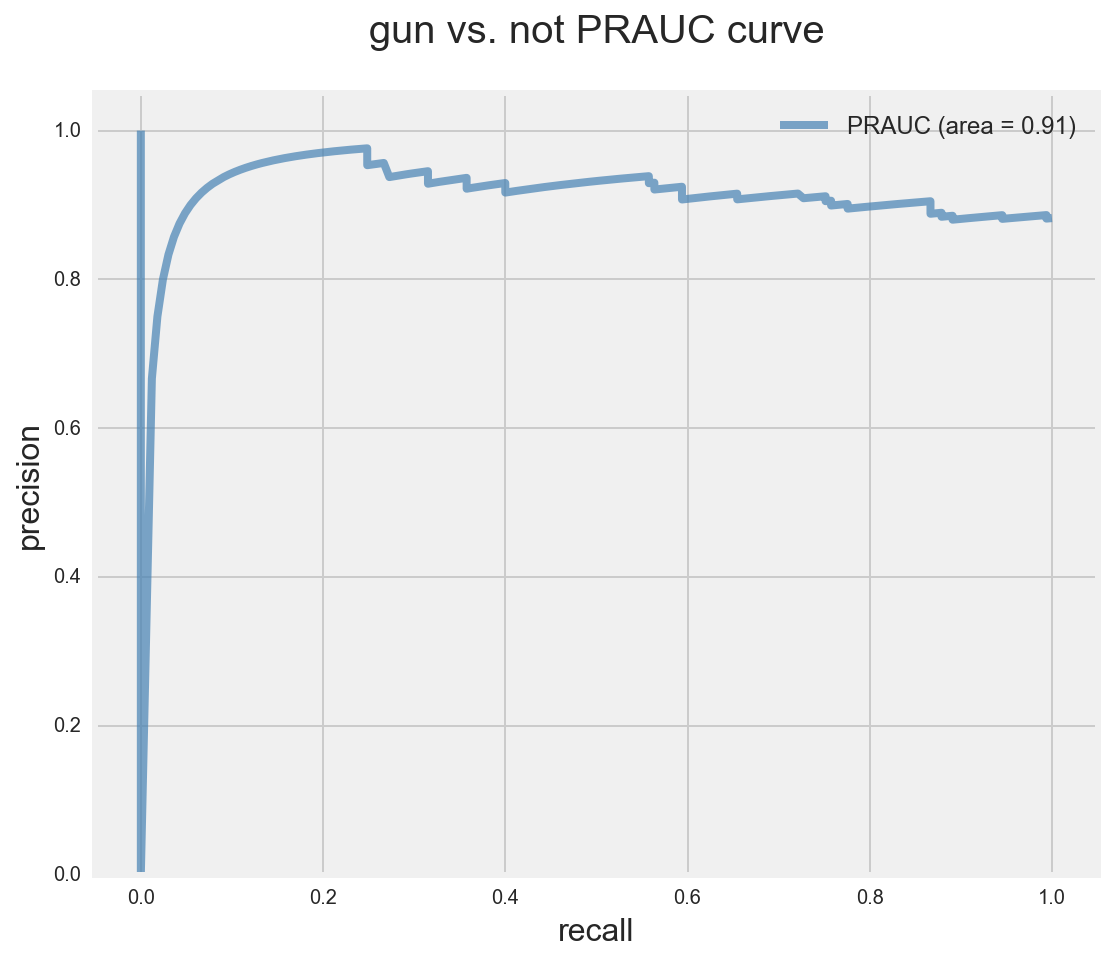

In [122]:
plot_prauc(gun_lr, X_gun_test, y_gun_test, 'gun')

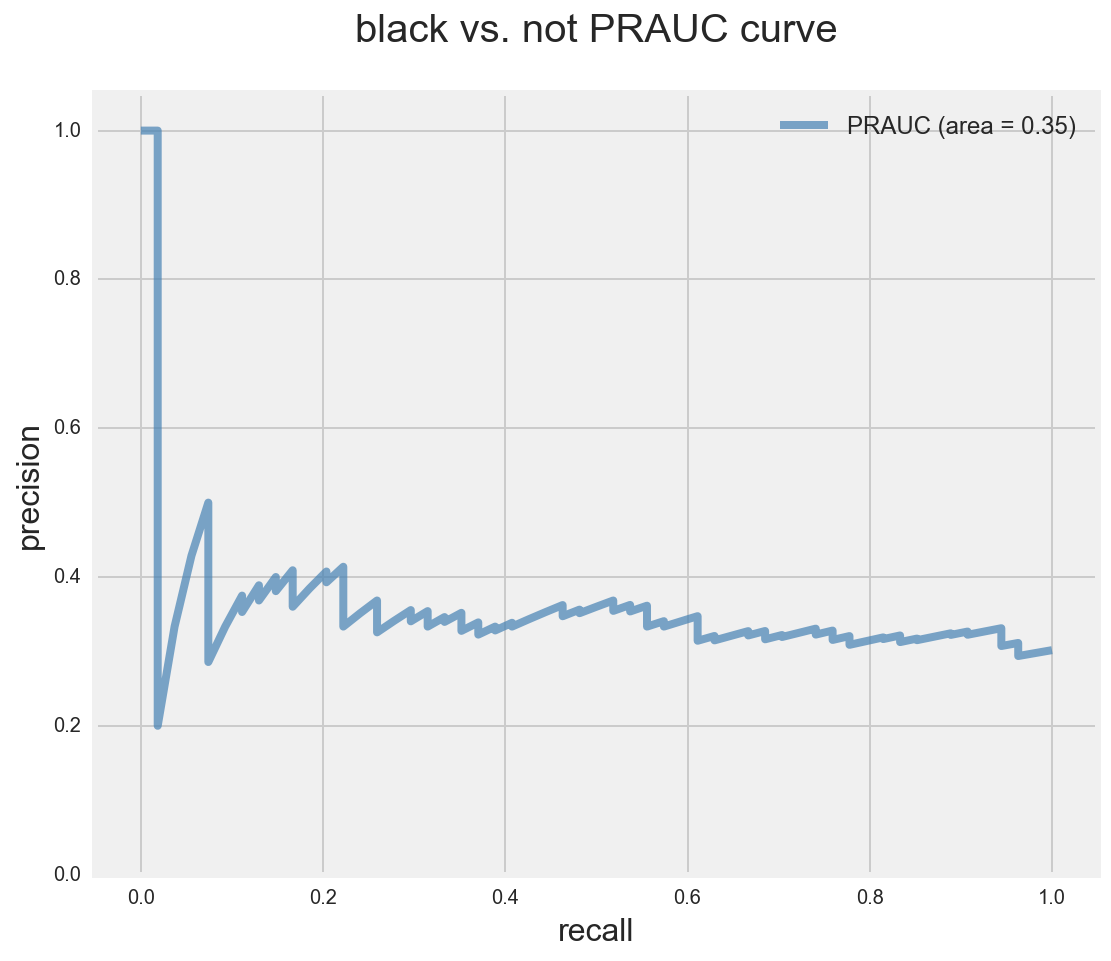

In [123]:
plot_prauc(black_lr, X_blk_test, y_blk_test, 'black')

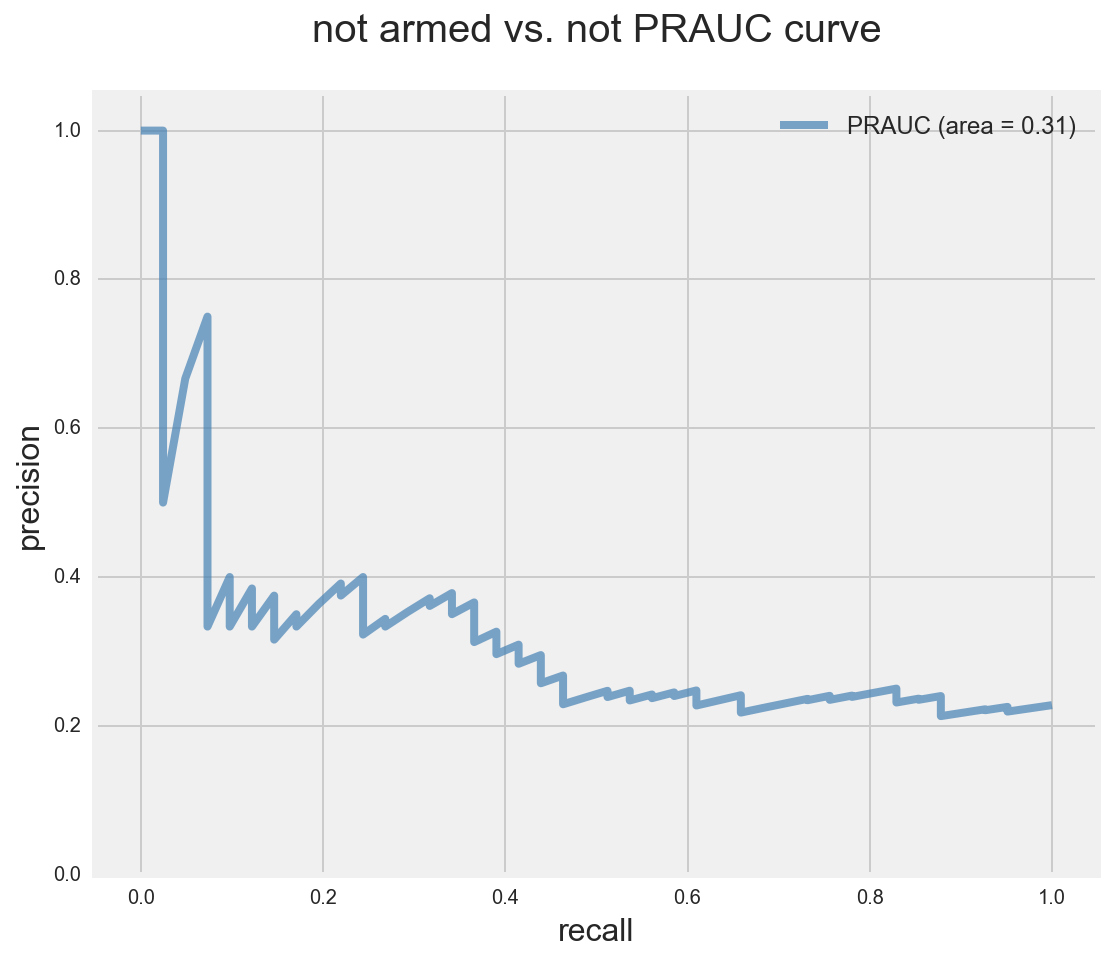

In [124]:
plot_prauc(notarmed_lr, X_narm_test, y_narm_test, 'not armed')

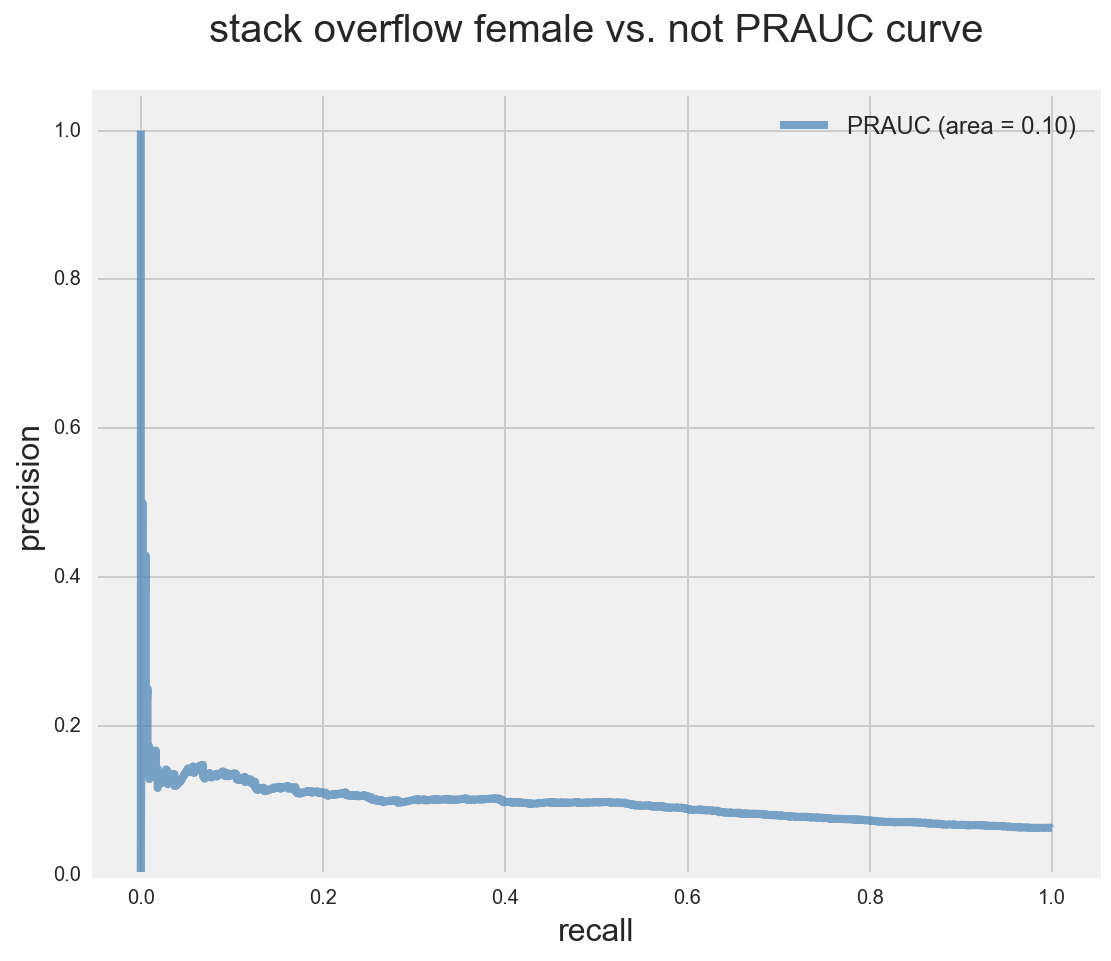

In [125]:
plot_prauc(sof_lr, Xso_f_test, yso_f_test, 'stack overflow female')

---

### Run new gridsearches with keyword argument `scoring='f1'` for your data

The f1-score is a metric combining performance on both precision and recall. It is similar to area under the precision recall curve.  

Setting the scoring to this will now have the gridsearch optimize the parameters to find the best f1-score as opposed to the best accuracy!

In [126]:
gun_pr_gs = GridSearchCV(LogisticRegression(), lr_params, 
                           cv=10, verbose=1, scoring='f1')
notarmed_pr_gs = GridSearchCV(LogisticRegression(), lr_params, 
                              cv=10, verbose=1, scoring='f1')
black_pr_gs = GridSearchCV(LogisticRegression(), lr_params, 
                           cv=10, verbose=1, scoring='f1')
sof_pr_gs = GridSearchCV(LogisticRegression(), lr_params, 
                         cv=5, verbose=1, scoring='f1')


gun_pr_gs.fit(X_gun_train, y_gun_train)
notarmed_pr_gs.fit(X_narm_train, y_narm_train)
black_pr_gs.fit(X_blk_train, y_blk_train)
sof_pr_gs.fit(Xso_f_train, yso_f_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.2s finished
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.7s finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.3s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-04,   2.04083e+01,   4.08164e+01,   6.12246e+01,
         8.16327e+01,   1.02041e+02,   1.22449e+02,   1.42857e+02,
         1.63265e+02,   1.83674e+02,   2.04082e+02,   2.24490e+02,
         2.44898e+02,   2.65306e+02,   2.85714e+02,   3.0...7e+02,   9.38776e+02,   9.59184e+02,
         9.79592e+02,   1.00000e+03]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=1)

In [132]:
gun_pr_lr = gun_pr_gs.best_estimator_
print gun_pr_gs.best_params_
print gun_pr_gs.best_score_

notarmed_pr_lr = notarmed_pr_gs.best_estimator_
print notarmed_pr_gs.best_params_
print notarmed_pr_gs.best_score_

black_pr_lr = black_pr_gs.best_estimator_
print black_pr_gs.best_params_
print black_pr_gs.best_score_

sof_pr_lr = sof_pr_gs.best_estimator_
print sof_pr_gs.best_params_
print sof_pr_gs.best_score_

{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.935302338965
{'penalty': 'l1', 'C': 836.73471020408158, 'solver': 'liblinear'}
0.2
{'penalty': 'l1', 'C': 163.26538979591837, 'solver': 'liblinear'}
0.373925698485
{'penalty': 'l1', 'C': 959.18367755102031, 'solver': 'liblinear'}
0.0238190668583


---

### Calculate the confusion matrices using the new models on the train or test data.

Has anything changed? Why would that be the case?

In [133]:
calc_confusion_matrix(gun_pr_lr, X_gun_train, y_gun_train, margins=True)

Predicted,1.0,All
True,,
0.0,19,19
1.0,155,155
All,174,174


In [134]:
calc_confusion_matrix(notarmed_pr_lr, X_narm_train, y_narm_train, margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,123,15,138
1.0,31,3,34
All,154,18,172


In [135]:
calc_confusion_matrix(black_pr_lr, X_blk_train, y_blk_train, margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,90,22,112
1.0,35,14,49
All,125,36,161


In [136]:
calc_confusion_matrix(sof_pr_lr, Xso_f_train, yso_f_train, margins=True)

Predicted,0,1,All
True,,,
0,12093,10,12103
1,803,10,813
All,12896,20,12916
